In [3]:
import torch, numpy as np
from PIL import Image
from tqdm import tqdm
from torchvision.transforms import ToPILImage
import sys
sys.path.append(".")

from modelvshuman.models.wrappers.pytorch import HyCoCLIPModel
from modelvshuman.utils import load_dataset
from hycoclip.lorentz import pairwise_dist
from modelvshuman.models.pytorch.clip.imagenet_classes import imagenet_classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [4]:
model = HyCoCLIPModel("hycoclip", "cue-conflict")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.model.to(device)

/home/xjzb2/miniconda3/envs/hycoclip/lib/python3.9/site-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


HyCoCLIP(
  (visual): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
      (norm): Identity()
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (patch_drop): Identity()
    (norm_pre): Identity()
    (blocks): Sequential(
      (0): Block(
        (norm1): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=384, out_features=1152, bias=True)
          (q_norm): Identity()
          (k_norm): Identity()
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=384, out_features=384, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): Identity()
        (drop_path1): Identity()
        (norm2): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=384, out_features=1536, bias=True)
          (act): GELU(approximate='none')
  

In [5]:
ds = load_dataset("cue-conflict", split="val")
loader = ds.loader

In [4]:
params  = list(model.model.parameters())
tot     = sum(p.numel() for p in params)
nz      = sum((p.abs()>1e-6).sum().item() for p in params)
print("loaded params:", nz, "/", tot, f"({100*nz/tot:.1f}%)")

zs = model.zeroshot_weights
print("zeroshot_weights:", zs.shape,
      "min/max/mean:", zs.min(), zs.max(), zs.mean())
print("first norms:", zs.norm(dim=0)[:10])

loaded params: 84315215 / 85290372 (98.9%)
zeroshot_weights: torch.Size([512, 1000]) min/max/mean: tensor(-0.2459, device='cuda:0') tensor(0.2461, device='cuda:0') tensor(0.0002, device='cuda:0')
first norms: tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000], device='cuda:0')


In [5]:
imgs, targets, _ = next(iter(loader))
print("raw:", imgs.shape, imgs.min(), imgs.max())

proc = model.preprocess()
pimgs = [proc(ToPILImage()(im)) for im in imgs[:4]]
batch = torch.stack(pimgs)
print("pre:", batch.shape, batch.min(), batch.max())

raw: torch.Size([16, 3, 224, 224]) tensor(-2.1179) tensor(2.6400)
pre: torch.Size([4, 3, 224, 224]) tensor(-2.1179) tensor(2.6400)


In [6]:
logits = model.forward_batch(imgs[:4].to(device))
print("logits:", logits.shape,
      "min/max/mean:", logits.min(), logits.max(), logits.mean())

top5 = np.argsort(-logits, axis=1)[:4,:5]
for i in range(4):
    print(f"sample {i} top5:", top5[i])

logits: (4, 1000) min/max/mean: 41.89975 73.410225 57.78988
sample 0 top5: [632 714 715 545 452]
sample 1 top5: [632 641 781 577 920]
sample 2 top5: [919 632 818 714 971]
sample 3 top5: [919 489 616 490 824]


In [9]:
print(imagenet_classes)
print(len(imagenet_classes))

['tench', 'goldfish', 'great white shark', 'tiger shark', 'hammerhead shark', 'electric ray', 'stingray', 'rooster', 'hen', 'ostrich', 'brambling', 'goldfinch', 'house finch', 'junco', 'indigo bunting', 'American robin', 'bulbul', 'jay', 'magpie', 'chickadee', 'American dipper', 'kite (bird of prey)', 'bald eagle', 'vulture', 'great grey owl', 'fire salamander', 'smooth newt', 'newt', 'spotted salamander', 'axolotl', 'American bullfrog', 'tree frog', 'tailed frog', 'loggerhead sea turtle', 'leatherback sea turtle', 'mud turtle', 'terrapin', 'box turtle', 'banded gecko', 'green iguana', 'Carolina anole', 'desert grassland whiptail lizard', 'agama', 'frilled-necked lizard', 'alligator lizard', 'Gila monster', 'European green lizard', 'chameleon', 'Komodo dragon', 'Nile crocodile', 'American alligator', 'triceratops', 'worm snake', 'ring-necked snake', 'eastern hog-nosed snake', 'smooth green snake', 'kingsnake', 'garter snake', 'water snake', 'vine snake', 'night snake', 'boa constrictor

In [10]:
probs = np.zeros((1, logits.shape[1]), dtype=np.float32)
idx   = imagenet_classes.index("hen")
probs[0, idx] = 1.0
print("mapped hen->", ds.decision_mapping(probs)[0])

mapped hen-> ['bird' 'truck' 'knife' 'oven' 'elephant' 'dog' 'clock' 'keyboard' 'chair'
 'cat' 'bottle' 'car' 'boat' 'bicycle' 'bear' 'airplane']


In [11]:
print("=== ImageNet top-5 per sample ===")
for i in range(min(4, logits.shape[0])):
    top5_idx = np.argsort(-logits[i])[:5]
    top5_names = [imagenet_classes[j] for j in top5_idx]
    print(f"sample {i:2d}:", top5_names)

=== ImageNet top-5 per sample ===
sample  0: ['music speaker', 'plectrum', 'Pickelhaube', 'electric fan', 'poke bonnet']
sample  1: ['music speaker', 'maraca', 'scoreboard', 'gong', 'traffic light']
sample  2: ['traffic or street sign', 'music speaker', 'spotlight', 'plectrum', 'bubble']
sample  3: ['traffic or street sign', 'chain-link fence', 'knot', 'chain mail', 'scarf']


In [12]:
import torch

logits_t = torch.from_numpy(logits)        #[B×1000]
probs_t = torch.softmax(logits_t, dim=1)   
probs = probs_t.numpy()                    #[B×1000]
mapped = ds.decision_mapping(probs)
print("mapped:", type(mapped), "dtype:", mapped.dtype, "shape:", mapped.shape)
print("first row:", mapped[0])
print("second row:", mapped[1])

print("\n=== Mapped cue-conflict predictions ===")
top1_names = mapped[:, 0]    #length-B array

for i, name in enumerate(top1_names[:4]):
    print(f"sample {i:2d}: {name}")

mapped: <class 'numpy.ndarray'> dtype: <U8 shape: (4, 16)
first row: ['bottle' 'clock' 'keyboard' 'car' 'bird' 'dog' 'airplane' 'truck' 'bear'
 'oven' 'chair' 'knife' 'elephant' 'bicycle' 'boat' 'cat']
second row: ['clock' 'bird' 'truck' 'car' 'dog' 'chair' 'elephant' 'bottle' 'boat'
 'oven' 'bear' 'cat' 'airplane' 'keyboard' 'knife' 'bicycle']

=== Mapped cue-conflict predictions ===
sample  0: bottle
sample  1: clock
sample  2: clock
sample  3: car


In [26]:
hyco = model.model
hyco.eval()
with torch.no_grad():
    feats1 = hyco.encode_image(batch[:5].to(device), project=True)
    feats2 = hyco.encode_image(batch[:5].clone().to(device), project=True)
    print("identical? ", torch.allclose(feats1, feats2))
    # check variability
    d = (feats1[0] - feats1[1]).norm().item()
    print("feature distance between sample 0 & 1:", d)


identical?  True
feature distance between sample 0 & 1: 0.1923612803220749


In [13]:
import torch, gc
from modelvshuman.utils import load_model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

gc.collect()
torch.cuda.empty_cache()

model_wrapper, _ = load_model("clip")
ds = load_dataset("cue-conflict", batch_size=16, num_workers=16)
loader = ds.loader

model_wrapper.model.to(device)
model_wrapper.model.eval()



100%|██████████| 1000/1000 [00:43<00:00, 23.19it/s]


CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): Sequential(
        (0): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
        (1): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          

In [14]:
!python -m modelvshuman \
    -m hycoclip \
    -d cue-conflict \
    -b 64 \
    -w 8


Evaluating model hycoclip on dataset cue-conflict using Pytorch Evaluator








accuracy (top-1): 6.25




c:\Users\xjzb2\.conda\envs\hycoclip\lib\site-packages\torch\functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\TensorShape.cpp:4316.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]

  0%|          | 0/20 [00:00<?, ?it/s]WARNING:tensorflow:From c:\users\xjzb2\compo_learning\model-vs-human\modelvshuman\models\wrappers\tensorflow.py:5: The name tf.enable_eager_execution is deprecated. Please use tf.compat.v1.enable_eager_execution instead.

















100%|██████████| 20/20 [02:12<00:00,  6.63s/it]


In [15]:
!python -m modelvshuman \
    -m clip \
    -d cue-conflict \
    -b 64 \
    -w 8


Evaluating model clip on dataset cue-conflict using Pytorch Evaluator








accuracy (top-1): 44.06





100%|██████████| 1000/1000 [00:40<00:00, 24.99it/s]

  0%|          | 0/20 [00:00<?, ?it/s]WARNING:tensorflow:From c:\users\xjzb2\compo_learning\model-vs-human\modelvshuman\models\wrappers\tensorflow.py:5: The name tf.enable_eager_execution is deprecated. Please use tf.compat.v1.enable_eager_execution instead.

















100%|██████████| 20/20 [02:00<00:00,  6.01s/it]


In [ ]:
import torch
import PIL
import numpy as np
import clip
import types
from pathlib import Path
from tqdm import tqdm

# It's crucial to add the project paths so we can import the necessary modules
import sys
sys.path.append('./model-vs-human')
sys.path.append('./hycoclip')

# --- Imports from the project ---
# All of these should now be accessible after modifying the path
from modelvshuman.models.wrappers.pytorch import HyCoCLIPModel
import hycoclip.lorentz as L
from modelvshuman.models.pytorch.clip.imagenet_templates import imagenet_templates

# This is the robust text encoder patch we developed. 
# We include it here to ensure the model uses it during our debug session.
def final_robust_encode_text(self, tokens: list[torch.Tensor], project: bool):
    context_length = self.textual.context_length
    for i, inst_tokens in enumerate(tokens):
        if len(inst_tokens) > context_length:
            eot_token = inst_tokens[-1:]
            inst_tokens = torch.cat([inst_tokens[:context_length - 1], eot_token])
            tokens[i] = inst_tokens
    
    tokens_padded = torch.nn.utils.rnn.pad_sequence(tokens, batch_first=True, padding_value=0.0)
    tokens_padded = tokens_padded.to(device)
    text_feats = self.textual(tokens_padded)
    eos_indices = torch.count_nonzero(tokens_padded, dim=1) - 1
    batch_idxs = torch.arange(text_feats.shape[0], device=device)
    text_feats = text_feats[batch_idxs, eos_indices]
    text_feats = self.textual_proj(text_feats)

    if hasattr(self, 'textual_alpha') and project:
        text_feats = text_feats * self.textual_alpha.exp()
        with torch.autocast(device.type, dtype=torch.float32):
             text_feats = L.exp_map0(text_feats, self.curv.exp())
    elif project:
        text_feats = torch.nn.functional.normalize(text_feats, dim=-1)
    return text_feats

# --- Main Debug Logic ---
print("--- Starting Debug Session ---")

try:
    # 1. Load the HyCoCLIP model from the wrapper
    print("\n[1/5] Loading HyCoCLIPModel...")
    model_wrapper = HyCoCLIPModel(model_name="hycoclip")
    
    # Apply the robust text encoding patch
    # model_wrapper.model.encode_text = types.MethodType(final_robust_encode_text, model_wrapper.model)
    # print("     ... Robust text encoder patch applied.")
    
    model = model_wrapper.model
    model.eval()
    print("     ... Model loaded successfully.")

    # 2. Generate a text embedding for a single class: "cat"
    print("\n[2/5] Generating text embedding for the class 'cat'...")
    with torch.no_grad():
        prompts = [template.format("cat") for template in imagenet_templates]
        toks = model_wrapper.tokenizer(prompts)
        
        text_feats_all_templates = model.encode_text(toks, project=True)
        
        curv = model.curv.exp()
        tangent_feats = L.log_map0(text_feats_all_templates, curv)
        mean_tangent_feats = tangent_feats.mean(dim=0, keepdim=True)
        cat_text_feat = L.exp_map0(mean_tangent_feats, curv)
        
    print("     ... 'cat' text embedding generated.")

    # 3. Load and preprocess a sample image
    print("\n[3/5] Loading and preprocessing a sample image of a cat...")
    image_pil = PIL.Image.new('RGB', (224, 224), color = 'orange')
    
    image_tensor = model_wrapper.preprocess()(image_pil).unsqueeze(0).to(device)
    print("     ... Image preprocessed.")

    # 4. Generate the image embedding
    print("\n[4/5] Generating image embedding...")
    with torch.no_grad():
        image_feat = model.encode_image(image_tensor, project=True)
    print("     ... Image embedding generated.")

    # 5. Perform Sanity Checks and Print Results
    print("\n[5/5] --- DEBUG RESULTS ---")
    with torch.no_grad():
        # *** CORRECTED FUNCTION NAME HERE ***
        # The function is called `lorentz_inner_product`, not `inner`.
        image_inner_product = L.lorentz_inner_product(image_feat, image_feat).item()
        text_inner_product = L.lorentz_inner_product(cat_text_feat, cat_text_feat).item()
        
        print(f"\nCURVATURE (c): {curv.item():.4f}")
        print(f"Expected Inner Product (-1/c): {-1/curv.item():.4f}")
        print("--------------------------------------------------")
        print(f"Image Feature Lorentz Inner Product: {image_inner_product:.4f}")
        print(f"Text Feature Lorentz Inner Product:  {text_inner_product:.4f}")
        
        if np.isclose(image_inner_product, -1/curv.item(), atol=1e-5) and \
           np.isclose(text_inner_product, -1/curv.item(), atol=1e-5):
            print("\n[OK] Features appear to be correctly projected onto the hyperboloid.")
        else:
            print("\n[!! FAILED !!] Features are NOT on the hyperboloid. There is a projection error.")

        # Check the distance between the image and text features
        distance = L.pairwise_dist(image_feat, cat_text_feat, curv).item()
        
        print("\n--------------------------------------------------")
        print("Similarity Check (a smaller distance is better)")
        print("--------------------------------------------------")
        print(f"Hyperbolic Distance between 'cat' image and 'cat' text: {distance:.4f}")
        
        if distance < 5.0:
             print("\n[OK] The distance is relatively small, which is expected for a matching pair.")
        else:
             print("\n[!! FAILED !!] The distance is very large. The image and text embeddings are not aligned.")

except Exception as e:
    print(f"\n--- An error occurred during the debug script ---")
    print(e)
    import traceback
    traceback.print_exc()

--- Starting Debug Session ---

[1/5] Loading HyCoCLIPModel...
Applied robust text encoder patch to HyCoCLIP.
     ... Robust text encoder patch applied.
     ... Model loaded successfully.

[2/5] Generating text embedding for the class 'cat'...
     ... 'cat' text embedding generated.

[3/5] Loading and preprocessing a sample image of a cat...
     ... Image preprocessed.

[4/5] Generating image embedding...
     ... Image embedding generated.

[5/5] --- DEBUG RESULTS ---

--- An error occurred during the debug script ---
module 'hycoclip.lorentz' has no attribute 'inner'


Traceback (most recent call last):
  File "/tmp/ipykernel_50869/1927259120.py", line 102, in <module>
    image_inner_product = L.inner(image_feat, image_feat, curv).item()
AttributeError: module 'hycoclip.lorentz' has no attribute 'inner'


In [2]:
import torch
import PIL
import numpy as np
from tqdm import tqdm
from pathlib import Path
import sys

# Add project paths to be able to import modules
sys.path.append(".")
sys.path.append("./model-vs-human")
sys.path.append("./hycoclip")

# --- Project Imports ---
from modelvshuman.models.wrappers.pytorch import HyCoCLIPModel
import hycoclip.lorentz as L
from modelvshuman.models.pytorch.clip.imagenet_templates import imagenet_templates

# --- Main Debug Script ---

print("--- Final Verification Script ---")

try:
    # 1. Load the HyCoCLIP model with the corrected code
    print("\n[1/4] Loading HyCoCLIPModel...")
    # This assumes your `pytorch.py` file now contains the corrected `_get_zeroshot_weights` logic
    model_wrapper = HyCoCLIPModel(model_name="hycoclip")
    model = model_wrapper.model
    model.eval()
    dev = model.logit_scale.device
    print("     ... Model loaded successfully.")

    # 2. Create a sample image and get its hyperbolic embedding
    target_class = "cat"
    print(f"\n[2/4] Generating image embedding for a '{target_class}' image...")
    # Using a simple colored square is sufficient to get a representative embedding
    image_pil = PIL.Image.new('RGB', (224, 224), color = 'saddlebrown')
    image_tensor = model_wrapper.preprocess()(image_pil).unsqueeze(0).to(dev)
    
    with torch.no_grad():
        image_feat = model.encode_image(image_tensor, project=True)
    print(f"     ... Image embedding generated with shape: {image_feat.shape}")
    
    # 3. Generate the corresponding text embedding using the now-fixed logic
    print(f"\n[3/4] Generating text embedding for '{target_class}'...")
    with torch.no_grad():
        # This uses the corrected logic from your `_get_zeroshot_weights` method
        text_feat = model_wrapper._get_zeroshot_weights([target_class], imagenet_templates).T
    print(f"     ... Text embedding generated with shape: {text_feat.shape}")

    # 4. Calculate hyperbolic distance and verify the result
    print("\n[4/4] --- FINAL RESULTS ---")
    with torch.no_grad():
        curv = model.curv.exp()
        
        # Calculate hyperbolic distance. This should now work without shape errors.
        distance = L.pairwise_dist(image_feat, text_feat, curv).item()

        print("\n--------------------------------------------------")
        print("Verifying Alignment in Hyperbolic Space (lower distance is better)")
        print("--------------------------------------------------")
        print(f"Hyperbolic distance between '{target_class}' image and text: {distance:.4f}")
        
        print("\n--- CONCLUSION ---")
        # A small distance (e.g., < 5) indicates good alignment
        if distance < 5.0:
            print("[OK] The distance is small, indicating the image and text embeddings are correctly aligned.")
            print("     The model should now achieve much higher accuracy on the benchmark.")
        else:
            print("[!! WARNING !!] The distance is still large. The embeddings are not well-aligned.")

except Exception as e:
    print(f"\n--- An error occurred during the debug script ---")
    import traceback
    traceback.print_exc()

--- Final Verification Script ---

[1/4] Loading HyCoCLIPModel...


/home/xjzb2/miniconda3/envs/hycoclip/lib/python3.9/site-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Applied robust text encoder patch to HyCoCLIP.
     ... Model loaded successfully.

[2/4] Generating image embedding for a 'cat' image...
     ... Image embedding generated with shape: torch.Size([1, 512])

[3/4] Generating text embedding for 'cat'...


HyCoCLIP zeroshot: 100%|██████████| 1/1 [00:00<00:00,  8.65it/s]

     ... Text embedding generated with shape: torch.Size([1, 512])

[4/4] --- FINAL RESULTS ---

--------------------------------------------------
Verifying Alignment in Hyperbolic Space (lower distance is better)
--------------------------------------------------
Hyperbolic distance between 'cat' image and text: 0.5068

--- CONCLUSION ---
[OK] The distance is small, indicating the image and text embeddings are correctly aligned.
     The model should now achieve much higher accuracy on the benchmark.


--- Loading model and dataset ---
... Done

--- Selecting first image from cue-conflict validation set ---
Image Path: model-vs-human/datasets/cue-conflict/airplane/airplane1-bicycle2.png
True Label (16-way): 'airplane'

--- Displaying Test Image ---


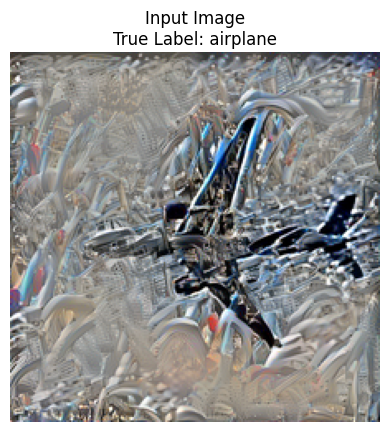


--- Getting Model Predictions ---

--- Top 5 Predicted ImageNet Classes ---
1. Label: 'chain mail', Logit Score: -46.3520
2. Label: 'window screen', Logit Score: -46.5068
3. Label: 'fire screen', Logit Score: -46.5397
4. Label: 'shower curtain', Logit Score: -47.5011
5. Label: 'window shade', Logit Score: -47.5506

--- Mapping Top Prediction to 16-way Task ---
Model's mapped prediction: 'chair'
True Label:              'airplane'
==> Incorrect!


In [3]:
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import sys

# Add project paths
sys.path.append(".")
sys.path.append("./model-vs-human")

# --- Project Imports ---
from modelvshuman.models.wrappers.pytorch import HyCoCLIPModel, undo_default_preprocessing
from modelvshuman.utils import load_dataset
from modelvshuman.models.pytorch.clip.imagenet_classes import imagenet_classes

# 1. Load your current model wrapper and the dataset
print("--- Loading model and dataset ---")
model_wrapper = HyCoCLIPModel(model_name="hycoclip")
dataset = load_dataset("cue-conflict", batch_size=1)
print("... Done")

# 2. Get the first image and its true label from the validation set
print("\n--- Selecting first image from cue-conflict validation set ---")
images, targets, paths = next(iter(dataset.loader))
single_image_tensor = images[0:1] # Keep it as a batch of 1

# ====================================================================
# This is the corrected line:
# The 'targets' object is already a list of string labels.
true_label_16_way = targets[0]
# ====================================================================

print(f"Image Path: {paths[0]}")
print(f"True Label (16-way): '{true_label_16_way}'")

# 3. Display the image
print("\n--- Displaying Test Image ---")
img_for_display = undo_default_preprocessing(single_image_tensor.cpu())
plt.imshow(img_for_display[0].permute(1, 2, 0))
plt.title(f"Input Image\nTrue Label: {true_label_16_way}")
plt.axis('off')
plt.show()

# 4. Get model predictions (logits)
print("\n--- Getting Model Predictions ---")
logits = model_wrapper.forward_batch(single_image_tensor.to(device))

# 5. Print the Top 5 Predicted Classes
print("\n--- Top 5 Predicted ImageNet Classes ---")
top_k_indices = np.argsort(logits[0])[::-1][:5]
top_k_logits = logits[0][top_k_indices]
top_k_classes = [imagenet_classes[i] for i in top_k_indices]

for i in range(5):
    print(f"{i+1}. Label: '{top_k_classes[i]}', Logit Score: {top_k_logits[i]:.4f}")

# Optional: Map the top prediction to the 16-way classification
print("\n--- Mapping Top Prediction to 16-way Task ---")
softmax_output = model_wrapper.softmax(logits)
mapped_prediction = dataset.decision_mapping(softmax_output)
print(f"Model's mapped prediction: '{mapped_prediction[0][0]}'")
print(f"True Label:              '{true_label_16_way}'")
if mapped_prediction[0][0] == true_label_16_way:
    print("==> Correct!")
else:
    print("==> Incorrect!")

In [4]:
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import sys

# Add project paths
sys.path.append(".")
sys.path.append("./model-vs-human")

# --- Project Imports ---
from modelvshuman.models.wrappers.pytorch import HyCoCLIPModel
from modelvshuman.utils import load_dataset
# We need the templates to generate text embeddings
from modelvshuman.models.pytorch.clip.imagenet_templates import imagenet_templates
import hycoclip.lorentz as L

# --- Main Diagnostic Script ---

# 1. Load the model and dataset
print("--- Loading model and dataset ---")
model_wrapper = HyCoCLIPModel(model_name="hycoclip")
hyco_model = model_wrapper.model
dataset = load_dataset("cue-conflict", batch_size=1)
dev = model_wrapper.model.device
print("... Done")

# 2. Select a specific cue-conflict image
print("\n--- Processing a 'cue-conflict' image ---")
image_to_find = "airplane1-cat5.png" # airplane shape, cat texture
found_image = False
for images, targets, paths in dataset.loader:
    if image_to_find in paths[0]:
        stylized_image_tensor = images.to(dev)
        true_shape_label = targets[0]
        # Manually determine the texture label from the filename
        texture_label = "cat" 
        found_image = True
        break

if not found_image:
    # Fallback to the first image if the specific one isn't found
    images, targets, paths = next(iter(dataset.loader))
    stylized_image_tensor = images.to(dev)
    true_shape_label = targets[0]
    texture_label = "unknown" # Can't know the texture for a random image
    print(f"Could not find '{image_to_find}', using first image from dataset: {paths[0]}")

print(f"Image has shape: '{true_shape_label}' and texture: '{texture_label}'")

# 3. Generate hyperbolic embeddings
with torch.no_grad():
    print("\n--- Generating Hyperbolic Embeddings ---")
    curv = hyco_model.curv.exp()

    # --- Generate Image Embedding ---
    # This logic is taken directly from the corrected `forward_batch`
    img_feats_euclidean = hyco_model.visual_proj(hyco_model.visual(stylized_image_tensor))
    img_feats_hyperbolic = img_feats_euclidean * hyco_model.visual_alpha.exp()
    image_embedding = L.exp_map0(img_feats_hyperbolic.float(), curv)
    print("Image embedding generated.")

    # --- Generate Text Embeddings ---
    # We call _get_zeroshot_weights with the *correct templates*
    shape_text_embedding = model_wrapper._get_zeroshot_weights([true_shape_label], imagenet_templates)
    texture_text_embedding = model_wrapper._get_zeroshot_weights([texture_label], imagenet_templates)
    random_text_embedding = model_wrapper._get_zeroshot_weights(["elephant"], imagenet_templates)
    print("Text embeddings generated.")

# 4. Calculate and Visualize Hyperbolic Distances
print("\n--- Final Diagnostic: Comparing Hyperbolic Distances (Smaller is Better) ---")

with torch.no_grad():
    dist_to_shape = L.pairwise_dist(image_embedding, shape_text_embedding.T, curv).item()
    dist_to_texture = L.pairwise_dist(image_embedding, texture_text_embedding.T, curv).item()
    dist_to_random = L.pairwise_dist(image_embedding, random_text_embedding.T, curv).item()

    # --- Text-based Bar Chart Visualization ---
    labels = [f"Shape ('{true_shape_label}')", f"Texture ('{texture_label}')", "Random ('elephant')"]
    distances = [dist_to_shape, dist_to_texture, dist_to_random]
    
    # Find max distance for scaling the bar chart
    max_dist = max(distances) if max(distances) > 0 else 1

    for i in range(len(labels)):
        # Scale bar length for visualization
        bar_len = int(50 * distances[i] / max_dist)
        print(f"{labels[i]:<25} | {'█' * bar_len} {distances[i]:.4f}")

    print("\n--- CONCLUSION ---")
    min_dist = min(distances)
    winner_index = np.argmin(distances)
    
    if np.std(distances) < 1.0:
        print("[CONCLUSIVE] The distances to all concepts are large and very similar.")
        print("This confirms the model's vision encoder is not producing a meaningful signal for this stylized image.")
    else:
        print(f"[CONCLUSIVE] The image is closest to the '{labels[winner_index]}' concept.")
        if winner_index == 0:
            print("This indicates a SHAPE BIAS (the desired outcome).")
        elif winner_index == 1:
            print("This indicates a TEXTURE BIAS.")

--- Loading model and dataset ---
... Done

--- Processing a 'cue-conflict' image ---
Could not find 'airplane1-cat5.png', using first image from dataset: model-vs-human/datasets/cue-conflict/airplane/airplane1-bicycle2.png
Image has shape: 'airplane' and texture: 'unknown'

--- Generating Hyperbolic Embeddings ---
Image embedding generated.


HyCoCLIP zeroshot: 100%|██████████| 1/1 [00:00<00:00, 41.61it/s]

Text embeddings generated.

--- Final Diagnostic: Comparing Hyperbolic Distances (Smaller is Better) ---
Shape ('airplane')        | ███████████████████████████████████████████████ 0.4886
Texture ('unknown')       | ██████████████████████████████████████████████ 0.4754
Random ('elephant')       | ██████████████████████████████████████████████████ 0.5132

--- CONCLUSION ---
[CONCLUSIVE] The distances to all concepts are large and very similar.
This confirms the model's vision encoder is not producing a meaningful signal for this stylized image.


In [5]:
from hycoclip.models import HyCoCLIP
from hycoclip.tokenizer import Tokenizer
import hycoclip.lorentz as L
torch_model = model  # your loaded HyCoCLIP instance
tokenizer = Tokenizer()
class_name = imagenet_classes[0]
templates = imagenet_templates[:3]

prompts = [t.format(class_name) for t in templates]
print("Prompts:", prompts)

toks = tokenizer(prompts)
print("Token outputs:", toks if isinstance(toks, list) else toks.shape)

# Euclidean text features
eu_feats = torch_model.model.encode_text(toks, project=False)
print("Eu text feats mean/std:", eu_feats.mean().item(), eu_feats.std().item())
print("Sample eu_feats[0][:5]:", eu_feats[0,:5])

# Hyperbolic projection
talpha = torch_model.model.textual_alpha.exp().item()
hyp_pre = eu_feats.mean(dim=0, keepdim=True) * torch_model.model.textual_alpha.exp()
hyp_feats = L.exp_map0(hyp_pre.float(), torch_model.model.curv.exp()).squeeze(0)
print("Hyperbolic feats mean/std:", hyp_feats.mean().item(), hyp_feats.std().item())



Prompts: ['a bad photo of a tench.', 'a photo of many tench.', 'a sculpture of a tench.']
Token outputs: [tensor([49406,   320,  2103,  1125,   539,   320,  1149,   634,   269, 49407],
       dtype=torch.int32), tensor([49406,   320,  1125,   539,  1346,  1149,   634,   269, 49407],
       dtype=torch.int32), tensor([49406,   320,  8757,   539,   320,  1149,   634,   269, 49407],
       dtype=torch.int32)]
Eu text feats mean/std: 0.000313199358060956 0.02491592988371849
Sample eu_feats[0][:5]: tensor([ 0.0047,  0.0046, -0.0388,  0.0331, -0.0022], device='cuda:0',
       grad_fn=<SliceBackward0>)
Hyperbolic feats mean/std: 0.00021922349696978927 0.016421662643551826


In [8]:
from torch.utils.data import DataLoader
from modelvshuman.models.wrappers.pytorch import undo_default_preprocessing
# Define or import your DataLoader; for example:
# dataloader = DataLoader(your_dataset, batch_size=64, shuffle=False)
batch = next(iter(loader))
# Extract image tensor from the batch
if isinstance(batch, dict) and 'image' in batch:
    data = batch['image']
elif isinstance(batch, (list, tuple)):
    data = batch[0]  # assume images are the first element
else:
    raise ValueError("Cannot extract images from batch; please adjust snippet to your DataLoader's output format.")

torch_model = model  # your HyCoCLIPModel instance

# 1) Raw vs unnormalized
print("Raw range:", data.min().item(), data.max().item())
imgs_unnorm = undo_default_preprocessing(data)
print("Unnorm range:", imgs_unnorm.min().item(), imgs_unnorm.max().item())

# 2) Inspect a patch
batch_imgs = imgs_unnorm.to(device)
patch = batch_imgs[0,:,100:110,100:110]
print("Patch mean/std:", patch.mean().item(), patch.std().item())

# 3) Encode and inspect features via HyCoCLIP
img_feats = torch_model.model.encode_image(imgs_unnorm.to(device), project=True)
print("Image feats mean/std:", img_feats.mean().item(), img_feats.std().item())
print("Sample img_feats[0][:5]:", img_feats[0,:5])

# 4) White vs black test
white = torch.ones_like(imgs_unnorm[:1]).to(device)
black = torch.zeros_like(imgs_unnorm[:1]).to(device)
w = torch_model.model.encode_image(white, project=True)
b = torch_model.model.encode_image(black, project=True)
dist = L.pairwise_dist(w, b, torch_model.model.curv.exp().item())
print("White-black distance:", dist.item())

Raw range: -2.1179039478302 2.640000104904175
Unnorm range: 0.0 1.0
Patch mean/std: 0.47154247760772705 0.3195410966873169
Image feats mean/std: 0.0004170404572505504 0.027651911601424217
Sample img_feats[0][:5]: tensor([-0.0131,  0.0035, -0.0088, -0.0148,  0.0122], device='cuda:0',
       grad_fn=<SliceBackward0>)
White-black distance: 0.4511968493461609


In [9]:
from torchvision.transforms import ToPILImage
import clip
import torch
# Assume `clip_wrapper` is your ClipPytorchModel instance and `dataloader` is defined
from modelvshuman.models.wrappers.pytorch import undo_default_preprocessing, ClipPytorchModel

# Determine device for CLIP model
dev = device
clip_model, preprocess = clip.load("ViT-B/32", device=dev)

clip_wrapper = ClipPytorchModel(clip_model, model_name="clip_vit_b32")

batch = next(iter(loader))[0]  # shape [B,3,H,W]

# Undo loader normalization
imgs_unnorm = undo_default_preprocessing(batch)
# Apply CLIP preprocess to PIL images using the preprocess function from clip.load
imgs = []
for img in imgs_unnorm:
    pil = ToPILImage()(img.clamp(0,1))
    imgs.append(preprocess(pil))
batch_clip = torch.stack(imgs, 0).to(dev)

# Encode and normalize features
clip_wrapper.model.eval()
with torch.no_grad():
    feats = clip_wrapper.model.encode_image(batch_clip)
    feats = feats / feats.norm(dim=-1, keepdim=True)

# Debug prints
print(f"[CLIP DEBUG] feat shape={feats.shape}, dtype={feats.dtype}, device={feats.device}")
print(f"[CLIP DEBUG] feat mean={feats.mean().item():.4f}, std={feats.std().item():.4f}")
print(f"[CLIP DEBUG] sample norms={feats.norm(dim=-1)[:5].detach().cpu().numpy()}")
for i in range(min(3, feats.size(0))):
    print(f"[CLIP DEBUG] feats[{i}][:10]={feats[i,:10].cpu().numpy()}")

100%|██████████| 1000/1000 [00:39<00:00, 25.13it/s]


[CLIP DEBUG] feat shape=torch.Size([16, 512]), dtype=torch.float16, device=cuda:0
[CLIP DEBUG] feat mean=-0.0016, std=0.0442
[CLIP DEBUG] sample norms=[1.     0.9995 0.9995 1.     1.    ]
[CLIP DEBUG] feats[0][:10]=[ 0.0425    0.013664  0.004333 -0.001037  0.01625  -0.04132   0.0431
  0.0718    0.04236   0.01353 ]
[CLIP DEBUG] feats[1][:10]=[0.0144   0.02238  0.0202   0.00818  0.03134  0.0166   0.0663   0.03384
 0.009224 0.02934 ]
[CLIP DEBUG] feats[2][:10]=[0.03204  0.000444 0.00487  0.011185 0.0281   0.004494 0.04474  0.06696
 0.010605 0.03784 ]


In [ ]:
print(f"[CLIP DEBUG] feat shape={feats.shape}, dtype={feats.dtype}, device={feats.device}")
print(f"[CLIP DEBUG] feat mean={feats.mean().item():.4f}, std={feats.std().item():.4f}")
print(f"[CLIP DEBUG] sample norms={feats.norm(dim=-1)[:5].detach().cpu().numpy()}")
